# Predicting Student Wait Time at LAIR for Stanford’s Introductory Computer Science Courses

## Project Group:
Sachin Allums (sachino)\
Justin Blumencranz (jmb25)\
Andrew Hong (amhong)\
Mahathi Mangipudi (mahathim)

Stanford enrolls over 2500 students each year in its two introductory computer science courses: CS106A and CS106B. These students have the opportunity to make use of LaIR, a space where they can receive one-on-one help from a section leader with their code for a given assignment. Currently, section leaders of the course are recommended to spend 15 minutes on each help request to better manage the flow of assistance. The purpose of our project is to develop a model that can predict how long students have to wait to receive help based on the assignment they are completing, the time they go to LaIR, and the number of days they go before the assignment deadline, among other features. 

# Model Selection

We have chosen to implement a linear regression model, which will take in a variety of features describing the context of a single LaIR request and output an estimated wait time for the student to recieve help.

***

First, let's import all of the neccesary packages for modeling and analysis

In [91]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy, math
from sklearn.model_selection import train_test_split

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

### Model Control Panel
Use the cell below to tweak the model for better performance

In [92]:
# Define split sizes
TRAIN_SIZE = 0.8
CV_SIZE = 0.1
TEST_SIZE = 0.1

# Model hyperparameters
LEARNING_RATE = 5.0e-3
ITERATIONS = 100000
LAMBDA = None
W_INIT = lambda n_features: np.random.randn(n_features) * 0.01

# Which Columns are Features
X_LABELS = [
    "numInQueue",
    "daysLeftClean",
    "bitAndKarel",
    "imagesAndGraphics",
    "mapsAndDictionaries",
    "lambdas",
    "fileReading",
    "grids",
    "strings",
    "userInteraction",
    "queuesAndStacks",
    "recursion",
    "structs",
    "objectOrientedProgramming",
    "pointersAndMemory",
    "sorting",
    "hashTables"
]

# Which Column is the label
Y_LABELS = "waitTime"

print(len(X_LABELS))

### Don't Touch Anything Below This Line

# Ensure splits add up to 100%
assert TRAIN_SIZE + CV_SIZE + TEST_SIZE == 1

17


Now we go get the data from our dataset and split it into TRAIN, VAL, and TEST sets! For this we use the handy `train_test_split` from `sklearn`

In [93]:
# File path to the dataset
dtype = {"waitTime": int, "daysLeftClean": float, "numInQueue": float}
dataset = pd.read_csv('master_database_March6_forModeling - master_database_March6 (1).csv', dtype=dtype)

# Split the data
train, test = train_test_split(dataset, test_size=1-TRAIN_SIZE)
test, crossValidation = train_test_split(test, test_size=TEST_SIZE/(1-TRAIN_SIZE))

# Print Set Sizes
print(f"Total number of examples: {len(dataset)}")
print(f"Sizes of TRAIN, CV, TEST: [{len(train)},{len(crossValidation)},{len(test)}]")


Total number of examples: 20237
Sizes of TRAIN, CV, TEST: [16189,2025,2023]


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_24621/3716270464.py:3: DtypeWarning: Columns (22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('master_database_March6_forModeling - master_database_March6 (1).csv', dtype=dtype)


Next we read in the features and labels

In [94]:
X_train = np.array(train[X_LABELS])
y_train = np.array(train[Y_LABELS])
X_cross = np.array(crossValidation[X_LABELS])
Y_cross = np.array(crossValidation[Y_LABELS])
X_test = np.array(test[X_LABELS])
y_test = np.array(test[Y_LABELS])

print(f"X Shape: {X_train.shape}, X Type:{type(X_train)})")
print(f"y Shape: {y_train.shape}, y Type:{type(y_train)})")
print(f"X CV Shape: {X_cross.shape}, X CV Type:{type(X_train)})")
print(f"y CV Shape: {Y_cross.shape}, y CV Type:{type(y_train)})")

X Shape: (16189, 17), X Type:<class 'numpy.ndarray'>)
y Shape: (16189,), y Type:<class 'numpy.ndarray'>)
X CV Shape: (2025, 17), X CV Type:<class 'numpy.ndarray'>)
y CV Shape: (2025,), y CV Type:<class 'numpy.ndarray'>)


In [95]:
def compute_error_bins(X, y, w, b):
    m = X.shape[0]

    f_wb = (X @ w) + b
    diff = abs(f_wb - y)
    
    small = diff[diff <= 2]
    medium = diff[(diff > 2) & (diff < 10)]
    large = diff[diff >= 10]
    
    return len(small), len(medium), len(large)

# Training Utility Functions
Below are the functions used to train the model using gradient decent with MSE cost.

In [96]:
def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    f_wb = (X @ w) + b
    error = (f_wb - y)
    return (error @ error) / (2 * m)

In [97]:
def compute_cost_regularized(X, y, w, b, lambda_=0): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    f_wb = (X @ w) + b
    error = (f_wb - y)
    regularization = (lambda_ / m) * (w @ w)
    return (error @ error) / (2 * m) + regularization

In [98]:
def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m = X.shape[0]
    error = (X @ w) + b - y
    dj_dw = (np.transpose(X) @ error) / m
    dj_db = np.sum(error) / m
    return dj_db, dj_dw 

In [99]:
def compute_gradient_regularized(X, y, w, b, lambda_=0): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m = X.shape[0]
    error = (X @ w) + b - y
    dj_dw = ((np.transpose(X) @ error) + (lambda_ * w)) / m
    dj_db = np.sum(error) / m
    return dj_db, dj_dw 

In [100]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

In [101]:
def predict(x, w, b): 
    """
    single predict using linear regression
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters   
      b (scalar):             model parameter 
      
    Returns:
      p (scalar):  prediction
    """
    return np.dot(x, w) + b      

Type of w: <class 'numpy.ndarray'>, and type of b: <class 'float'>
dj_db at initial w,b: -3.173305948483538
dj_dw at initial w,b: 
 [-65.294   2.266  -0.06   -0.901  -0.932  -0.153   0.143  -0.657  -0.056
  -0.213   0.157  -0.687  -1.124  -0.119  -0.536  -0.519  -0.025]
Iteration    0: Cost   112.97   
Iteration 10000: Cost    86.44   
Iteration 20000: Cost    86.35   
Iteration 30000: Cost    86.33   
Iteration 40000: Cost    86.32   
Iteration 50000: Cost    86.32   
Iteration 60000: Cost    86.32   
Iteration 70000: Cost    86.32   
Iteration 80000: Cost    86.31   
Iteration 90000: Cost    86.31   
b,w found by gradient descent: 5.89,[ 1.22  -0.    -2.379 -3.295  4.489  1.37  -5.066  3.224 -3.108  0.596
 -5.639 -1.51  -0.47   3.439 -0.523  2.791 -1.022] 
prediction: 28.43, target value: 18
prediction: 7.11, target value: 1
prediction: 63.80, target value: 88
prediction: 12.42, target value: 10
prediction: 13.26, target value: 17


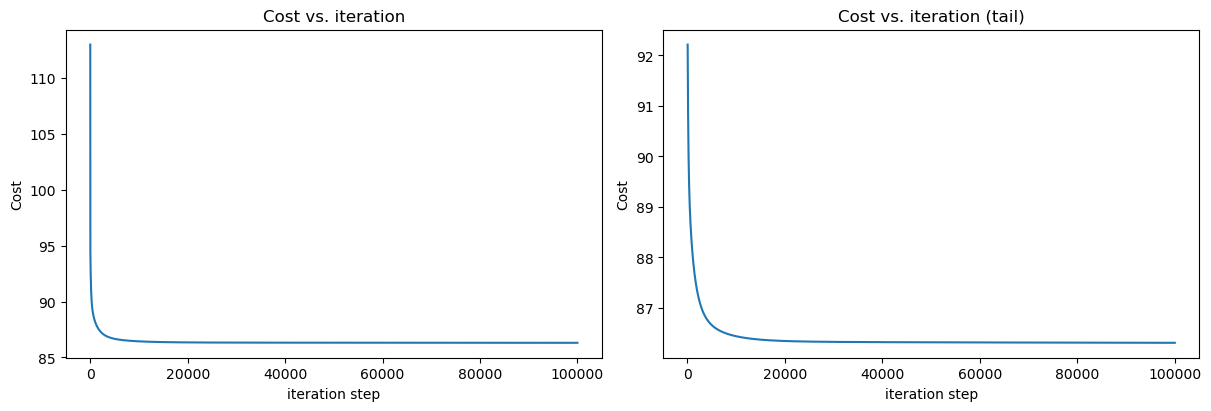

87.47349027317597
small error: 416, medium error: 1137, and large error: 472


In [102]:


b_init = 0.01
w_init = np.ones(len(X_LABELS))

print(f"Type of w: {type(w_init)}, and type of b: {type(b_init)}")

# # Compute and display cost using our pre-chosen optimal parameters. 
# cost = compute_cost(X_train, y_train, w_init, b_init)
# print(f'Cost at optimal w : {cost}')

#Compute and display gradient 
tmp_dj_db, tmp_dj_dw = compute_gradient_regularized(X_train, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.01
iterations = ITERATIONS
alpha = LEARNING_RATE

# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b,
                                                compute_cost_regularized, compute_gradient_regularized, 
                                                alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(5):
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

# Compute cost function for cross validation set
print(compute_cost_regularized(X_cross, Y_cross, w_final, b_final))
small, medium, large = compute_error_bins(X_cross, Y_cross, w_final, b_final)
print(f"small error: {small}, medium error: {medium}, and large error: {large}")

# # Plot for just numInQueue against Wait Time
# plt.scatter(X_train, y_train)
# plt.xlabel('Num in Queue')
# plt.ylabel('Wait Time')
# plt.title("Num In Queue vs Wait Time")
# plt.axline((0, b_final), slope=w_final, linewidth=4, color='r')
# plt.show()